# Project: Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm of your choice! 

Try to apply the techniques you have learnt, but also feel free to come up with innovative ideas and test them.

## Define the Task, Design the Agent, and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

In [1]:
## TODO: Train your agent here.
%load_ext autoreload
%autoreload 2

import sys
import csv
import pandas as pd
import numpy as np
import tensorflow as tf
from agents.DQLagent import DQLagent
from task_DQL_nopitchroll import Task

num_episodes = 3000
runtime = 6.                          # time limit of the episode
init_pose = np.zeros(6)                # initial pose
init_velocities = np.zeros(3)          # initial velocities
init_angle_velocities = np.zeros(3)    # initial angle velocities
target_pos = np.zeros(3)               # to be replaced on a per-episode basis

tf.reset_default_graph()

task = Task(init_pose, init_velocities, init_angle_velocities, runtime, target_pos)
agent = DQLagent(task) 

labels = ['time', 'i_episode', 'tgt_z', 'rewards', 'z', 
          'dz', 'vz', 'thrustz', 'action', 'rotor1_hz',
          'explore_p']
res = []

file_output = 'data.csv'  # file name for saved results

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)

    with tf.Session() as sess:
        # Initialize variables
        sess.run(tf.global_variables_initializer())

        for i_episode in range(1, num_episodes+1):
            res.append({x : [] for x in labels})
        
            #r, dir = get_random_rdir()         # select random target location
            #new_target_pos = np.array([r*dir[0], r*dir[1], 0.]) + init_pose[:3]
            new_target_pos = np.array([0., 0., 10.])

            state = agent.reset_episode(new_target_pos)  # start a new episode
        
            while True:
                action = agent.act(sess,state) 
                next_state, reward, done = task.step(action)
                agent.step(sess, action, reward, next_state, done)
                state = next_state
            
                # Monitoring
                to_write = [task.sim.time] + [i_episode] + [task.target_pos[2]] + \
                        [np.mean(reward)] + [task.sim.pose[2]]  + \
                        [task.sim.pose[2]-task.target_pos[2]] + [task.sim.v[2]] + \
                        [task.sim.thrustplusdrag[2]] + \
                        [action] + [task.rotor_speeds[0]] + \
                        [agent.explore_p]
                for ii in range(len(labels)):
                    res[i_episode-1][labels[ii]].append(to_write[ii])
                writer.writerow(to_write)
                if done:
                    print("\rEpisode = {:4d}, lastreward = {:7.3f}, score = {:7.3f} (best = {:7.3f})".format(
                        i_episode, np.mean(reward), agent.score, agent.best_score), end="")  # [debug]
                    break
            sys.stdout.flush()

Episode = 3000, lastreward =  -0.606, score =   0.218 (best =   0.408)

## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

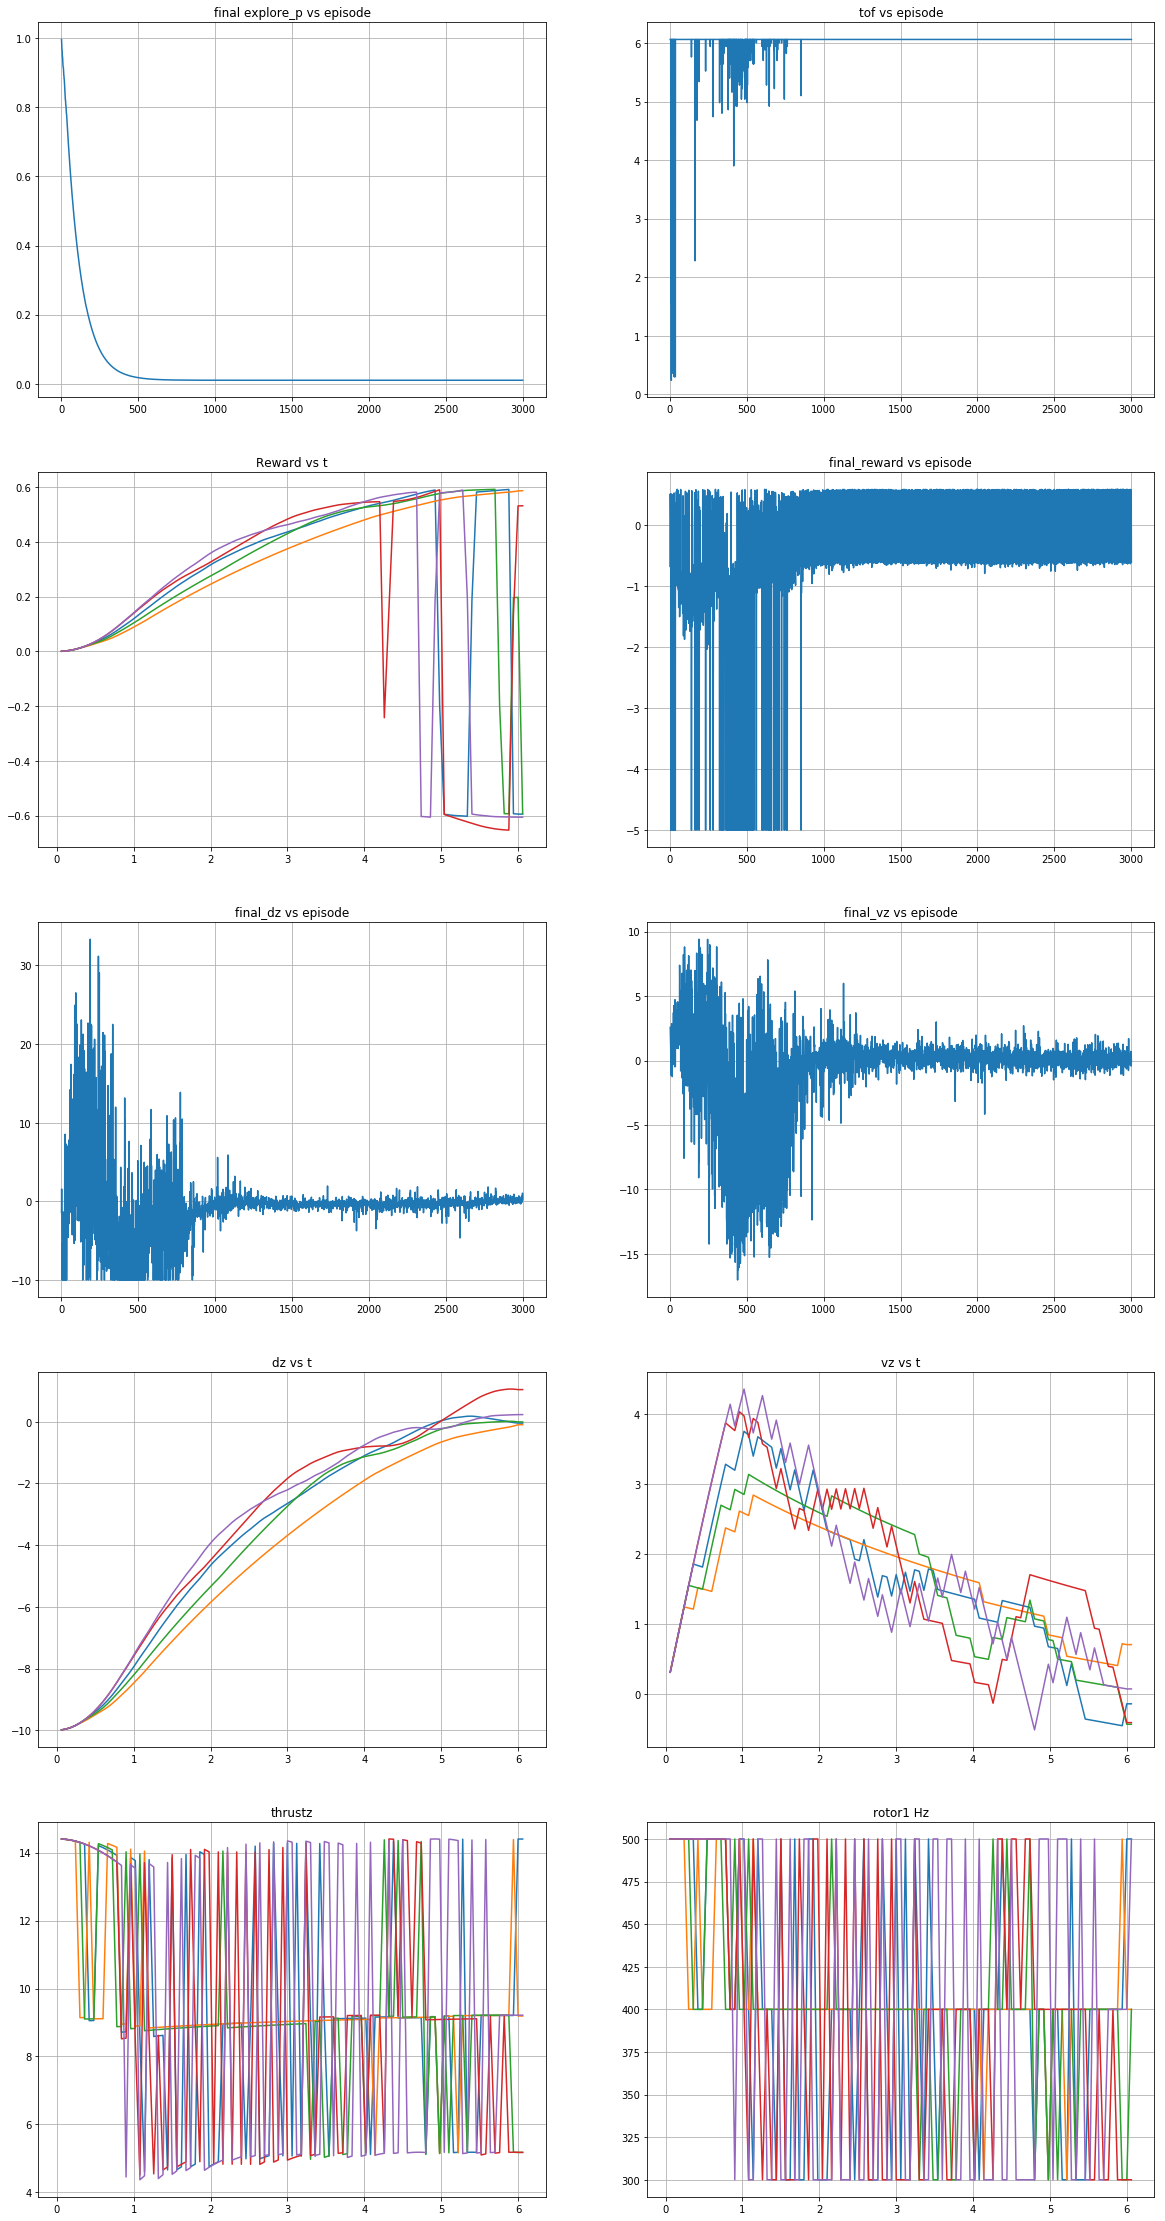

In [4]:
    ## TODO: Plot the rewards.
import matplotlib.pyplot as plt

titles = [
    ['final explore_p vs episode', 'tof vs episode'],
    ['Reward vs t', 'final_reward vs episode' ],
    ['final_dz vs episode', 'final_vz vs episode'],
    ['dz vs t', 'vz vs t'],
    ['thrustz', 'rotor1 Hz'],
]
nrows=len(titles)
ncols=len(titles[0])
fig, subs = plt.subplots(nrows,ncols,figsize=(20,40))
for i in range(nrows):
        for j in range(ncols):
            subs[i,j].set_title(titles[i][j])
            subs[i,j].grid()
            
#num_episodes=3000
totrange = range(num_episodes)

n=5
myrange = range(num_episodes-n,num_episodes)
#myrange=range(1000,1000+n)
#myrange = range(1,n)
#myrange = [180]
#myrange = totrange
#totrange = myrange

for i in myrange:
        #subs[0,0].plot(-np.log(-1*np.array(res[0]['rewards'])), label='Reward')
        subs[1,0].plot(res[i]['time'], res[i]['rewards'], label='Reward')
        subs[3,0].plot(res[i]['time'], res[i]['dz'], label='dz')
        subs[3,1].plot(res[i]['time'], res[i]['vz'], label='vz')
        subs[4,0].plot(res[i]['time'], res[i]['thrustz'], label='thrustz')
        subs[4,1].plot(res[i]['time'], res[i]['rotor1_hz'], label='rotor1_hz')

episodes  = [res[i]['i_episode'][0]+1 for i in totrange]
explore_p = [res[i]['explore_p'][-1] for i in totrange]; subs[0,0].plot(episodes, explore_p, label='explore_p')
tofs      = [res[i]['time'][-1] for i in totrange];      subs[0,1].plot(episodes, tofs, label='tof')
final_rwd = [res[i]['rewards'][-1] for i in totrange];   subs[1,1].plot(episodes, final_rwd, label='final_rwd')
final_zs  = [res[i]['dz'][-1] for i in totrange];        subs[2,0].plot(episodes, final_zs, label='final_dz')
final_vzs = [res[i]['vz'][-1] for i in totrange];        subs[2,1].plot(episodes, final_vzs, label='final_vz')

### Hover Task

In [5]:
## TODO: Train your agent here.
%load_ext autoreload
%autoreload 2

import sys
import csv
import pandas as pd
import numpy as np
import tensorflow as tf
from agents.DQLagent import DQLagent
from task_DQL_nopitchroll import Task

num_episodes = 3000
runtime = 5.                           # time limit of the episode
init_pose = np.zeros(6)                # initial pose
init_pose[2] = 20.0
init_velocities = np.zeros(3)          # initial velocities
init_angle_velocities = np.zeros(3)    # initial angle velocities
target_pos = np.zeros(3)               # to be replaced on a per-episode basis

tf.reset_default_graph()

task = Task(init_pose, init_velocities, init_angle_velocities, runtime, target_pos)
agent = DQLagent(task) 

labels = ['time', 'i_episode', 'tgt_z', 'rewards', 'z', 
          'dz', 'vz', 'thrustz', 'action', 'rotor1_hz',
          'delta_reward_from_max', 'explore_p']
res = []

file_output = 'data.csv'  # file name for saved results

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)

    with tf.Session() as sess:
        # Initialize variables
        sess.run(tf.global_variables_initializer())

        for i_episode in range(1, num_episodes+1):
            res.append({x : [] for x in labels})
        
            #r, dir = get_random_rdir()         # select random target location
            #new_target_pos = np.array([r*dir[0], r*dir[1], 0.]) + init_pose[:3]
            new_target_pos = np.array([0., 0., 20.])

            state = agent.reset_episode(new_target_pos)  # start a new episode
        
            while True:
                action = agent.act(sess,state) 
                next_state, reward, done = task.step(action)
                agent.step(sess, action, reward, next_state, done)
                state = next_state
            
                # Monitoring
                to_write = [task.sim.time] + [i_episode] + [task.target_pos[2]] + \
                        [np.mean(reward)] + [task.sim.pose[2]]  + \
                        [task.sim.pose[2]-task.target_pos[2]] + [task.sim.v[2]] + \
                        [task.sim.thrustplusdrag[2]] + \
                        [action] + [task.rotor_speeds[0]] + \
                        [reward - task.get_max_reward()] + [agent.explore_p]
                for ii in range(len(labels)):
                    res[i_episode-1][labels[ii]].append(to_write[ii])
                writer.writerow(to_write)
                if done:
                    print("\rEpisode = {:4d}, lastreward = {:7.3f}, score = {:7.3f} (best = {:7.3f})".format(
                        i_episode, np.mean(reward), agent.score, agent.best_score), end="")  # [debug]
                    break
            sys.stdout.flush()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Episode = 3000, lastreward =  -0.043, score =  -0.301 (best =  -0.001)

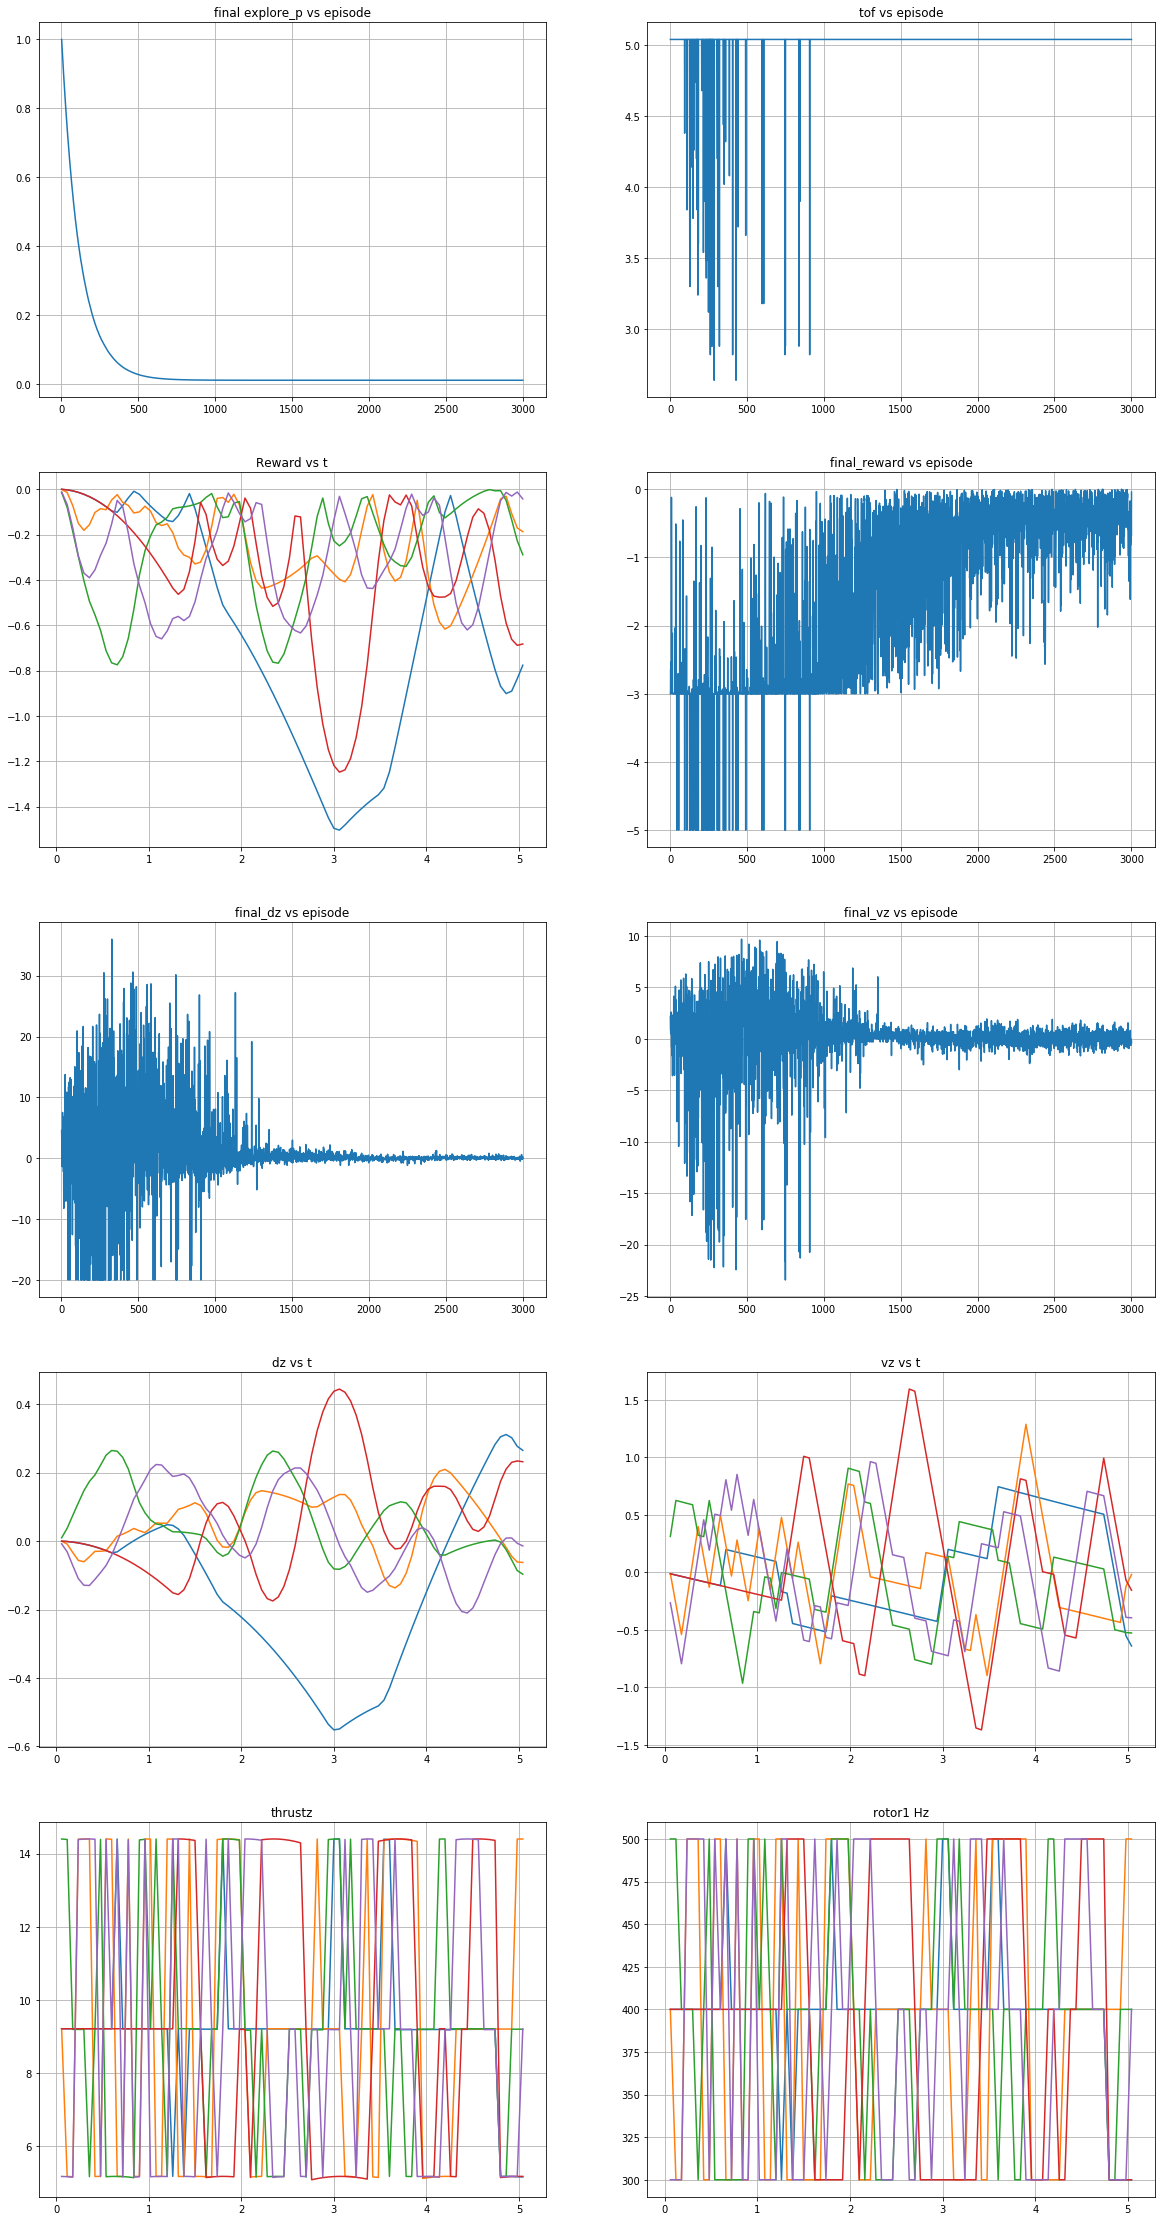

In [15]:
    ## TODO: Plot the rewards.
import matplotlib.pyplot as plt

titles = [
    ['final explore_p vs episode', 'tof vs episode'],
    ['Reward vs t', 'final_reward vs episode' ],
    ['final_dz vs episode', 'final_vz vs episode'],
    ['dz vs t', 'vz vs t'],
    ['thrustz', 'rotor1 Hz'],
]
nrows=len(titles)
ncols=len(titles[0])
fig, subs = plt.subplots(nrows,ncols,figsize=(20,40))
for i in range(nrows):
        for j in range(ncols):
            subs[i,j].set_title(titles[i][j])
            subs[i,j].grid()
            
#num_episodes=3000
totrange = range(num_episodes)

n=5
myrange = range(num_episodes-n,num_episodes)
#myrange=range(1000,1000+n)
#myrange = range(1,n)
#myrange = [2950]
#myrange = totrange
#totrange = myrange

for i in myrange:
        #subs[0,0].plot(-np.log(-1*np.array(res[0]['rewards'])), label='Reward')
        subs[1,0].plot(res[i]['time'], res[i]['rewards'], label='Reward')
        subs[3,0].plot(res[i]['time'], res[i]['dz'], label='dz')
        subs[3,1].plot(res[i]['time'], res[i]['vz'], label='vz')
        subs[4,0].plot(res[i]['time'], res[i]['thrustz'], label='thrustz')
        subs[4,1].plot(res[i]['time'], res[i]['rotor1_hz'], label='rotor1_hz')

episodes  = [res[i]['i_episode'][0]+1 for i in totrange]
explore_p = [res[i]['explore_p'][-1] for i in totrange]; subs[0,0].plot(episodes, explore_p, label='explore_p')
tofs      = [res[i]['time'][-1] for i in totrange];      subs[0,1].plot(episodes, tofs, label='tof')
final_zs  = [res[i]['dz'][-1] for i in totrange];        subs[2,0].plot(episodes, final_zs, label='final_dz')
final_vzs = [res[i]['vz'][-1] for i in totrange];        subs[2,1].plot(episodes, final_vzs, label='final_vz')
final_rwd = [res[i]['rewards'][-1] for i in totrange];   subs[1,1].plot(episodes, final_rwd, label='final_rwd')